# CS235 Fall 2025 Course Project

Name: William Nguyen

Student ID: 862549100

## Introduction
In this project, a number of data mining techniques that we cover in this class will be implemented and applied to a real-world imbalanced
dataset.

**Dataset:** Wisconsin Breast Cancer Diagnostic dataset from the UCI data repository: https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic

## Setup

1. Create new python environment for the project

- This is not necessary on Google Colab but a good practice on your local machine

2. Install the required packages

In [1]:
!pip install ucimlrepo

## Imports

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import itertools, collections
import numpy as np
import pandas as pd

from ucimlrepo import fetch_ucirepo
import warnings
warnings.filterwarnings("ignore")

## Load Data

In [3]:
# Fetch dataset
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17)

# Data (as pandas dataframes)
X = breast_cancer_wisconsin_diagnostic.data.features
y = breast_cancer_wisconsin_diagnostic.data.targets

# Metadata
print(breast_cancer_wisconsin_diagnostic.metadata)

X.head()

{'uci_id': 17, 'name': 'Breast Cancer Wisconsin (Diagnostic)', 'repository_url': 'https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic', 'data_url': 'https://archive.ics.uci.edu/static/public/17/data.csv', 'abstract': 'Diagnostic Wisconsin Breast Cancer Database.', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 569, 'num_features': 30, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['Diagnosis'], 'index_col': ['ID'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1993, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C5DW2B', 'creators': ['William Wolberg', 'Olvi Mangasarian', 'Nick Street', 'W. Street'], 'intro_paper': {'ID': 230, 'type': 'NATIVE', 'title': 'Nuclear feature extraction for breast tumor diagnosis', 'authors': 'W. Street, W. Wolberg, O. Mangasarian', 'venue': 'Electronic imaging', 'year': 1993, 'journal': None, 'DOI': '1

,radius1,texture1,perimeter1,area1,smoothness1,compactness1,concavity1,concave_points1,symmetry1,fractal_dimension1,...,radius3,texture3,perimeter3,area3,smoothness3,compactness3,concavity3,concave_points3,symmetry3,fractal_dimension3
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [4]:
# Encoded M and B into 0 and 1 for model training
y = y.replace({"M": 0, "B": 1})
y.value_counts()

Diagnosis
1            357
0            212
Name: count, dtype: int64

## Exploratory Data Analysis (EDA)

### Pairwise correlation between features

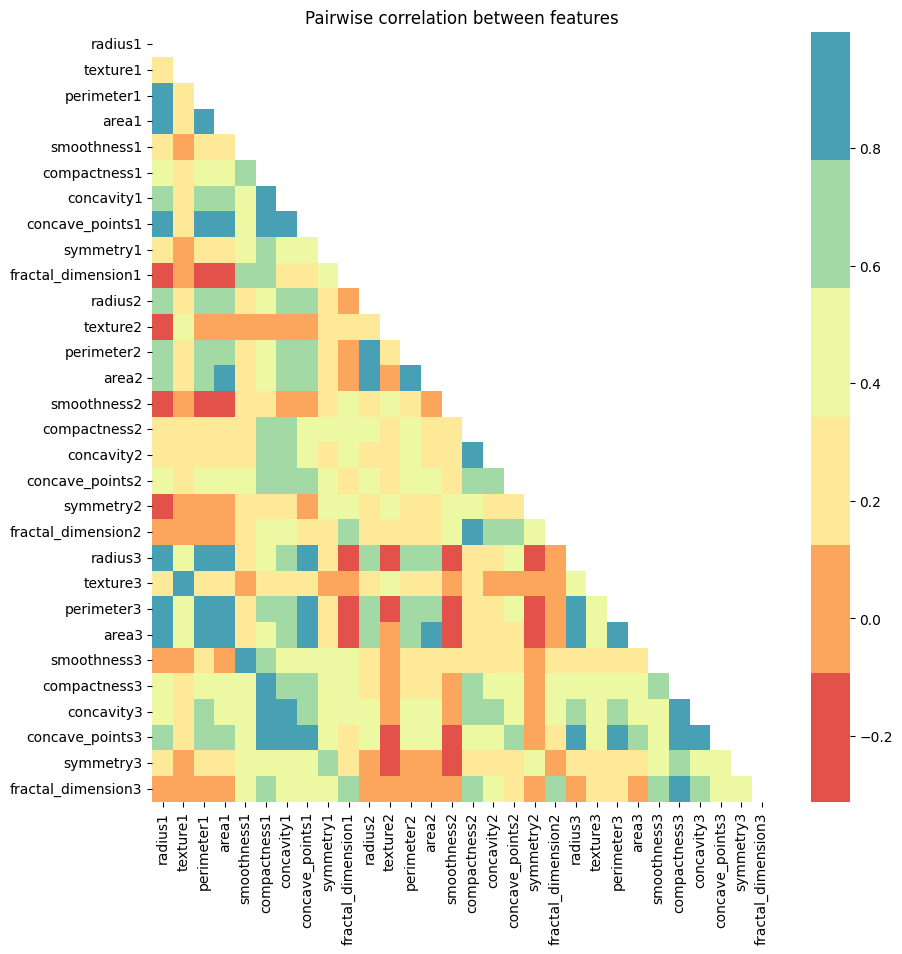

In [5]:
correlation = X.corr()

fig, ax = plt.subplots(1,1, figsize=(10,10))
sns.heatmap(correlation, annot=False, mask=np.triu(correlation),
            cmap=sns.color_palette("Spectral"))
ax.set_title("Pairwise correlation between features")
plt.show()

### Class Counts

In [6]:
print(collections.Counter(y['Diagnosis']))

Counter({1: 357, 0: 212})


### Class-wise features distributions

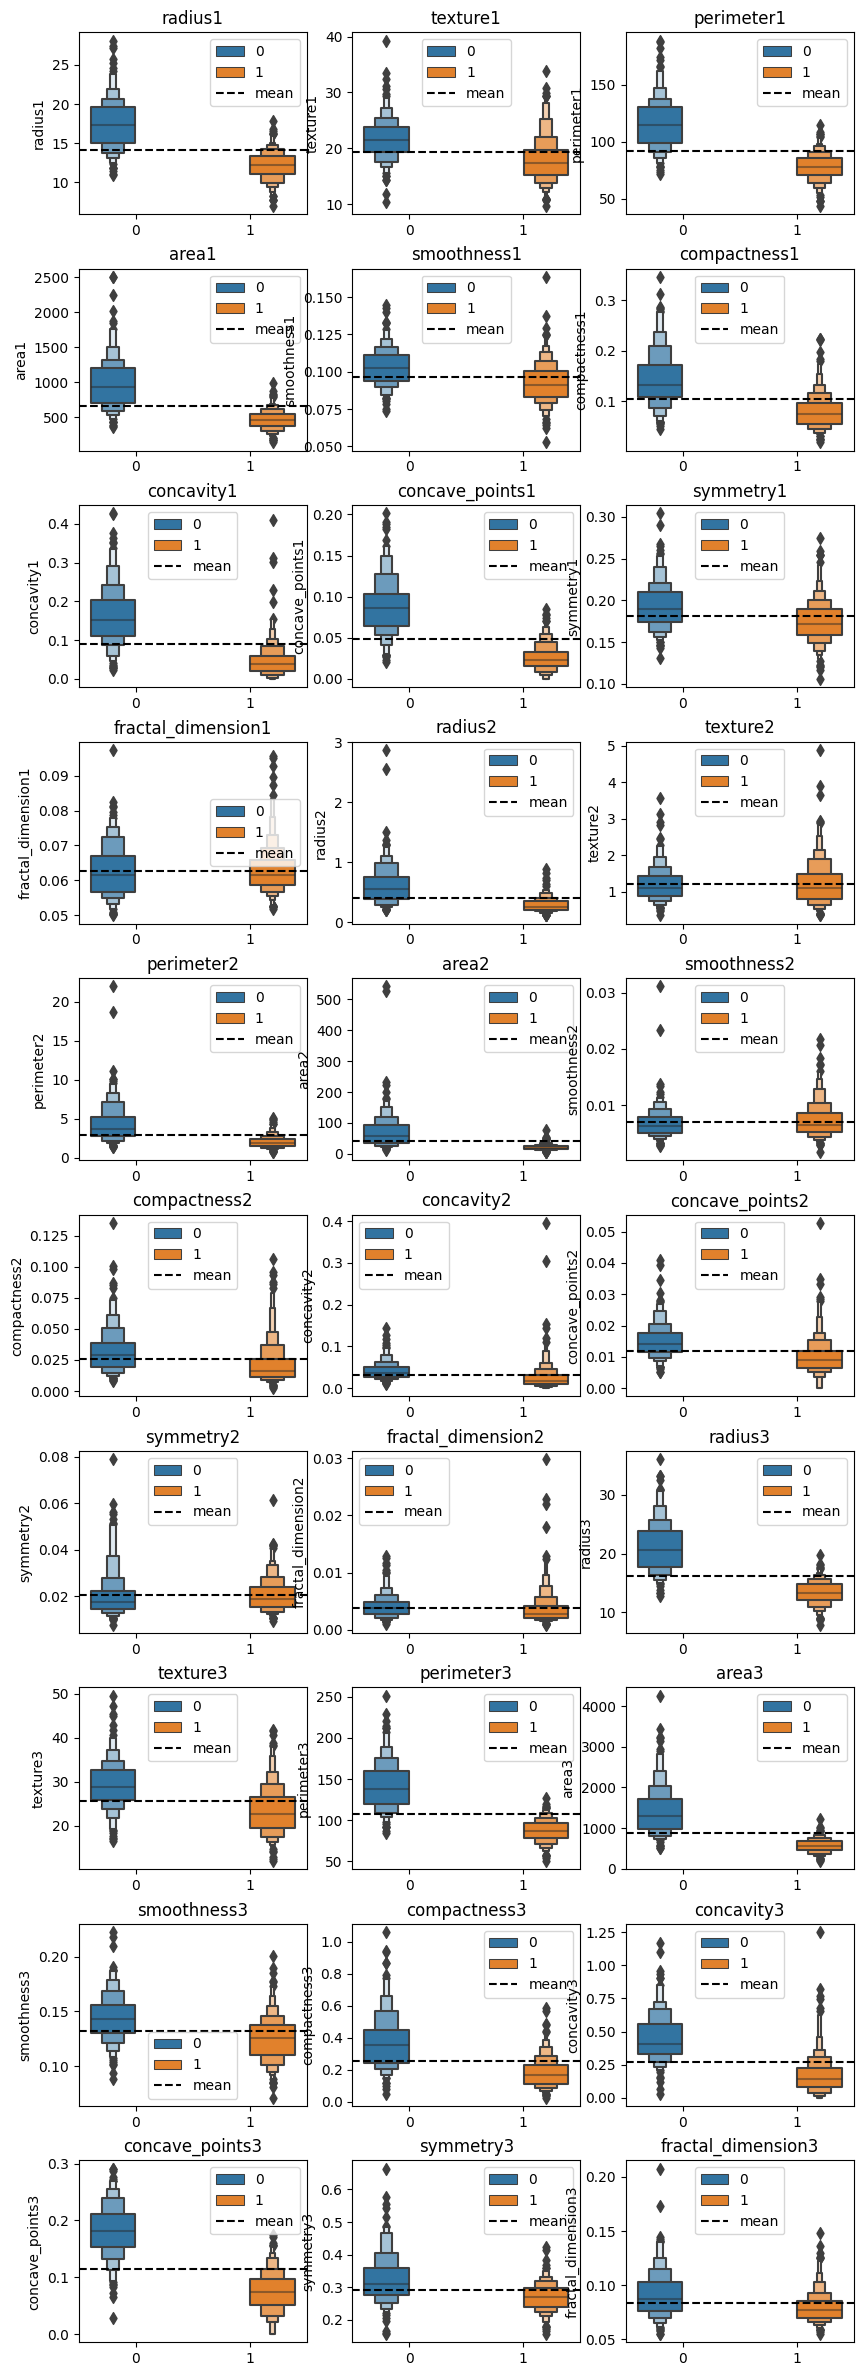

In [7]:
plt.figure(figsize=(10,30))

for i,j in itertools.zip_longest(list(X.columns), range(len(list(X.columns)))):
  plt.subplot(10,3,j+1)
  sns.boxenplot(x=y['Diagnosis'], y=X[i], hue=y['Diagnosis'])
  plt.title(i)
  plt.xlabel('')
  plt.subplots_adjust(hspace=.3)
  plt.axhline(X[i].mean(), linestyle="dashed", color='k', label='mean')
  plt.legend(loc='best')

# Phase 1 - Supervised Techniques

## Q1 - Implementing simple classifiers

[INSERT HERE: a brief description of how
you went about implementing the solution to the question]

In [8]:
# Data Splitting
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # split 5 times and shuffle

In [9]:
# Decision Tree Classifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV # StratifiedKfold is essentially K-fold CV for classification datasets where the target variable is imbalanced
from sklearn.metrics import classification_report

dtc = DecisionTreeClassifier()

space = {
    "criterion": ["gini", "entropy"], # information gain criteria
    "max_depth": np.linspace(1, 10, 10, dtype=int), # controls the max depth of trees (deeper trees, more complex [lower bias, higher variance])
    "min_samples_split": np.linspace(2, 40, 20, dtype=int), # minimum number of samples per split (higer min splits leads to higher bias, lower variance)
}

dtc_grid = GridSearchCV(dtc, param_grid=space, scoring="f1", cv=skf, verbose=1, error_score="raise")
dtc_grid.fit(X_train, y_train)

dtc_pred = dtc_grid.predict(X_test)

print(classification_report(y_test, dtc_pred))
print(f"Best Parameters: {dtc_grid.best_params_}")

Fitting 5 folds for each of 400 candidates, totalling 2000 fits
              precision    recall  f1-score   support

           0       0.97      0.91      0.94        43
           1       0.95      0.99      0.97        71

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114

Best Parameters: {'criterion': 'entropy', 'max_depth': 4, 'min_samples_split': 2}


In [10]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()

space = {
    "priors": [None, [0.6, 0.4], [0.7, 0.3]], # represents prior beliefs of each class, for example, 0.6,0.4 meand 60% belong to class 0, 40% belongs to class 1
    "var_smoothing": np.logspace(-10,-1,100) # used to increase smoothing, making model less sensitive to outliers in the training data
}

gnb_grid = GridSearchCV(gnb, cv=skf, scoring='f1', verbose=1, param_grid=space, error_score="raise") # initialize GridSearchCV
gnb_grid.fit(X_train, y_train)

gnb_pred = gnb_grid.predict(X_test)

print(classification_report(y_test, gnb_pred))
print(f"Best Parameters: {gnb_grid.best_params_}")

Fitting 5 folds for each of 300 candidates, totalling 1500 fits
              precision    recall  f1-score   support

           0       1.00      0.91      0.95        43
           1       0.95      1.00      0.97        71

    accuracy                           0.96       114
   macro avg       0.97      0.95      0.96       114
weighted avg       0.97      0.96      0.96       114

Best Parameters: {'priors': [0.7, 0.3], 'var_smoothing': 2.848035868435805e-09}


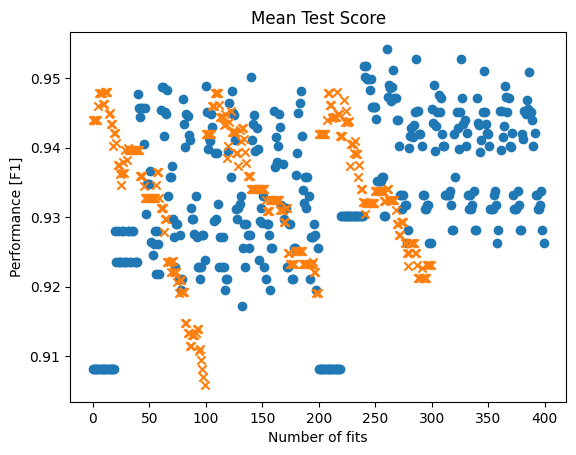

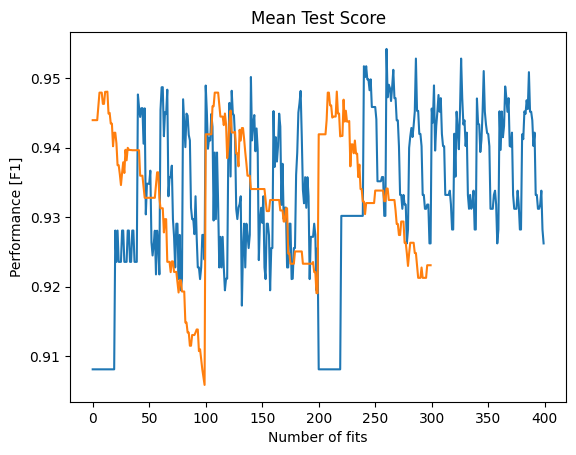

In [11]:
# Performance Comparison

# Mean Test Scores
dtc_scores = dtc_grid.cv_results_["mean_test_score"]
gnb_scores = gnb_grid.cv_results_["mean_test_score"]

# Scatter Plot
plt.scatter(range(len(dtc_scores)), dtc_grid.cv_results_["mean_test_score"], marker="o")
plt.scatter(range(len(gnb_scores)), gnb_grid.cv_results_["mean_test_score"], marker="x")
plt.title("Mean Test Score")
plt.xlabel("Number of fits")
plt.ylabel("Performance [F1]")
plt.show()

# Line Plot
plt.plot(dtc_grid.cv_results_["mean_test_score"])
plt.plot(gnb_grid.cv_results_["mean_test_score"])
plt.title("Mean Test Score")
plt.xlabel("Number of fits")
plt.ylabel("Performance [F1]")
plt.show()

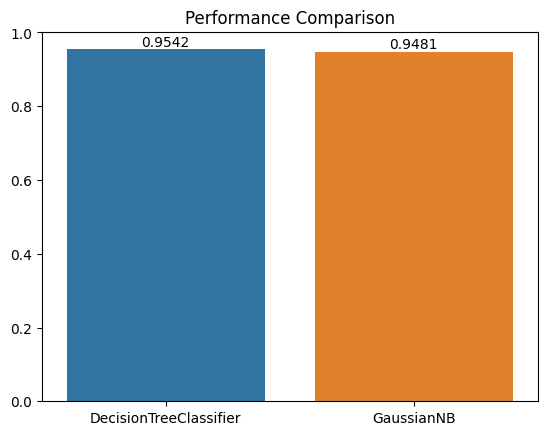

In [12]:
# Performance Comparison

performance_df = ({
    "Model": ["DecisionTreeClassifier", "GaussianNB"],
    "Performance": [dtc_grid.best_score_, gnb_grid.best_score_]
})

ax = sns.barplot(data=performance_df, x="Model", y="Performance")

for container in ax.containers:
    ax.bar_label(container, fmt="%.4f", label_type="edge")

plt.title("Performance Comparison")
plt.show()

## Q2 - Dimensionality reduction with the Singular Value Decomposition

[INSERT HERE: a brief description of how
you went about implementing the solution to the question]

In [13]:
# [YOUR IMPLEMENTATION CODE HERE]


In [14]:
# [YOUR PLOTTING CODE HERE]

## Q3 - Feature selection with randomization

[INSERT HERE: a brief description of how
you went about implementing the solution to the question]

In [15]:
# [YOUR IMPLEMENTATION CODE HERE]

In [16]:
# [YOUR PLOTTING CODE HERE]

## Q4 - Data augmentation using SMOTE

In [23]:
# [YOUR IMPLEMENTATION CODE HERE]
from imblearn.over_sampling import SMOTE


In [ ]:
# [YOUR PLOTTING CODE HERE]

# Sources

- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
- https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html
- https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html
- https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html